In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
!pip install tensorflow==2.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 17 kB/s 
     |████████████████████████████████| 462 kB 35.8 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949


In [ ]:
!nvidia-smi

Mon Oct  3 13:01:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
#import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE =224
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Fish_data/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4599 files belonging to 7 classes.


In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/Fish Dataset/train"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
class_names = dataset.class_names
class_names

['Centropristis striata',
 'Dawkinsia singhala',
 'Devario aequipinnatus',
 'Katsuwonus pelamis',
 'Lactarius lactarius',
 'Mullus surmuletus',
 'Scomber scombrus']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 224, 224, 3)
[0 5 0 0 4 3 6 4 0 0 5 6 5 6 0 0]


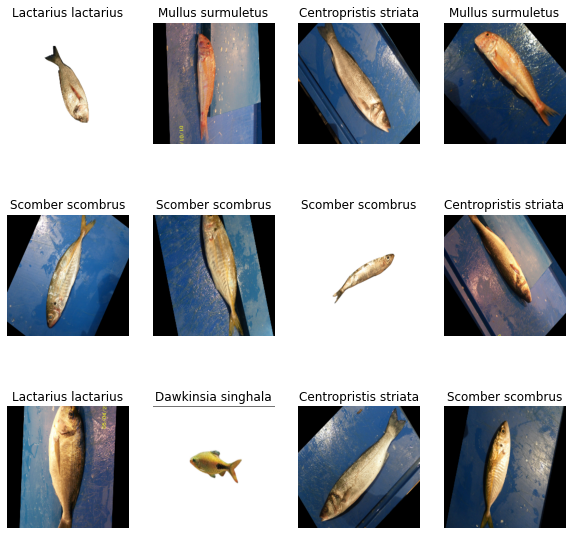

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

288

In [ ]:
train_size = 0.8
len(dataset)*train_size

230.4

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

234

In [ ]:
val_size=0.1
len(dataset)*val_size

28.8

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

230

In [ ]:
len(val_ds)

28

In [ ]:
len(test_ds)

30

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# re-size all the images to this
IMAGE_SIZE_new = [224, 224]

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE_new + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Fish_data/train/*')

In [ ]:
folders

['/content/drive/MyDrive/Fish_data/train/Katsuwonus pelamis',
 '/content/drive/MyDrive/Fish_data/train/Dawkinsia singhala',
 '/content/drive/MyDrive/Fish_data/train/Centropristis striata',
 '/content/drive/MyDrive/Fish_data/train/Lactarius lactarius',
 '/content/drive/MyDrive/Fish_data/train/Devario aequipinnatus',
 '/content/drive/MyDrive/Fish_data/train/Mullus surmuletus',
 '/content/drive/MyDrive/Fish_data/train/Scomber scombrus']

In [ ]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
230/230 [==============================] - 164s 210ms/step - loss: 1.9019 - accuracy: 0.9191 - val_loss: 0.4511 - val_accuracy: 0.9688
Epoch 2/20
230/230 [==============================] - 14s 59ms/step - loss: 0.4090 - accuracy: 0.9760 - val_loss: 0.3539 - val_accuracy: 0.9888
Epoch 3/20
230/230 [==============================] - 14s 59ms/step - loss: 0.2450 - accuracy: 0.9899 - val_loss: 0.3494 - val_accuracy: 0.9888
Epoch 4/20
230/230 [==============================] - 14s 59ms/step - loss: 0.1437 - accuracy: 0.9956 - val_loss: 0.4947 - val_accuracy: 0.9866
Epoch 5/20
230/230 [==============================] - 14s 59ms/step - loss: 0.1334 - accuracy: 0.9940 - val_loss: 0.0655 - val_accuracy: 0.9978
Epoch 6/20
230/230 [==============================] - 15s 64ms/step - loss: 0.2076 - accuracy: 0.9924 - val_loss: 0.6299 - val_accuracy: 0.9844
Epoch 7/20
230/230 [==============================] - 14s 59ms/step - loss: 0.1695 - accuracy: 0.9929 - val_loss: 0.2292 - val_accurac

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_inception.h5')

In [ ]:
import tensorflow as tf

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("restnet_test55.tflite", 'wb') as f:
  f.write(tflite_model)

In [ ]:
import os

In [ ]:
labels = [folder for folder in os.listdir('/content/drive/MyDrive/Fish_data/train') if not folder.startswith('.')]

with open('labelsres.txt', 'w') as f:
    for label in labels:
      f.write(label)
      f.write('\n')


In [ ]:
scores = model.evaluate(test_ds)

30/30 [==============================] - 34s 54ms/step - loss: 0.3383 - accuracy: 0.9979


In [ ]:
scores

[0.338320255279541, 0.9979166388511658]

In [ ]:
r.params

{'verbose': 1, 'epochs': 20, 'steps': 230}

In [ ]:
r.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
len(r.history['loss'])

20

In [ ]:
r.history['loss'][:5] # show loss for first 5 epochs

[1.9019373655319214,
 0.4090310335159302,
 0.24503707885742188,
 0.14365200698375702,
 0.13340550661087036]

first image to predict
actual label: Lactarius lactarius
predicted label: Lactarius lactarius


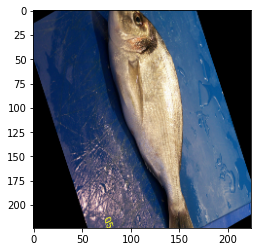

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

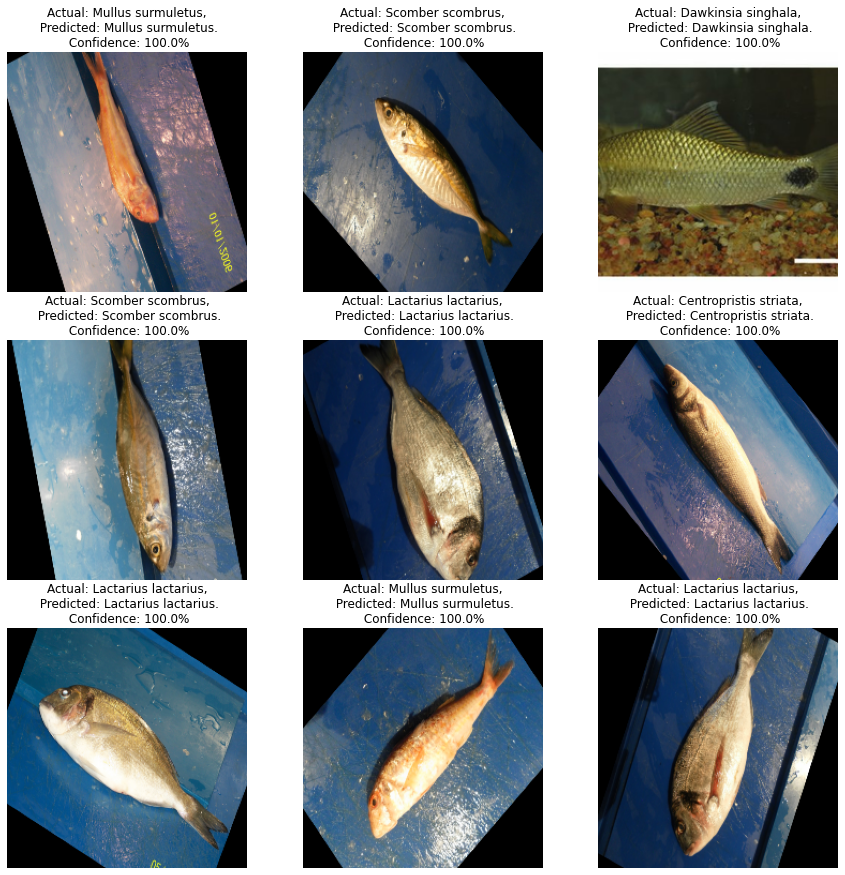

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")